In [1]:
import numpy as np
import pandas as pd
import h5py
 
import PIL
import matplotlib.image as img
import matplotlib.pyplot as plt
import io, os

from sklearn.model_selection import train_test_split

In [2]:
import pathlib
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input,  MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, add
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tqdm import tqdm

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. train data 불러오기

In [4]:
save_path = '/content/drive/MyDrive/Kaggle_Study/나은/new-26.h5'

h5f = h5py.File(save_path, 'r')
data1 = h5f.get('images')[()]
print(data1[:10])
h5f.close()

[[[[203 205 204]
   [203 205 204]
   [203 205 204]
   ...
   [202 208 208]
   [201 207 207]
   [201 207 207]]

  [[203 205 204]
   [203 205 204]
   [203 205 204]
   ...
   [200 206 206]
   [199 205 205]
   [199 205 205]]

  [[201 203 202]
   [203 205 204]
   [202 204 203]
   ...
   [200 206 206]
   [198 204 204]
   [198 204 204]]

  ...

  [[150 142 129]
   [150 142 129]
   [150 142 129]
   ...
   [169 174 176]
   [167 172 175]
   [166 170 173]]

  [[150 142 129]
   [150 142 129]
   [150 142 129]
   ...
   [167 171 174]
   [165 169 172]
   [163 167 170]]

  [[148 140 127]
   [148 140 127]
   [150 142 129]
   ...
   [165 169 172]
   [163 167 170]
   [161 165 168]]]


 [[[202 204 203]
   [202 204 203]
   [202 204 203]
   ...
   [202 206 207]
   [202 206 207]
   [202 206 207]]

  [[202 204 203]
   [202 204 203]
   [202 204 203]
   ...
   [202 206 207]
   [200 204 205]
   [200 204 205]]

  [[201 203 202]
   [203 205 204]
   [202 204 203]
   ...
   [201 205 206]
   [200 204 205]
   [200 204

In [56]:
np.shape(data1)

(48000, 64, 64, 3)

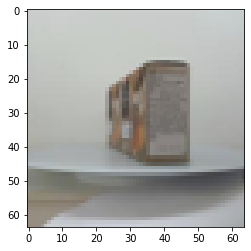

In [5]:
plt.imshow(data1[0])
plt.show()

## 3-2. train label 만들기

In [6]:
name_labels = pd.read_csv("/content/drive/MyDrive/Kaggle_Study/나은/names_labels.csv", header=None,index_col=0)
name_labels = name_labels.transpose()

In [7]:
name_labels

,NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,...,47960.0,47961.0,47962.0,47963.0,47964.0,47965.0,47966.0,47967.0,47968.0,47969.0,47970.0,47971.0,47972.0,47973.0,47974.0,47975.0,47976.0,47977.0,47978.0,47979.0,47980.0,47981.0,47982.0,47983.0,47984.0,47985.0,47986.0,47987.0,47988.0,47989.0,47990.0,47991.0,47992.0,47993.0,47994.0,47995.0,47996.0,47997.0,47998.0,47999.0
1,0,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,797,...,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986,986


In [8]:
name_labels = name_labels.values.tolist()[0]

In [9]:
name_labels = name_labels[1:]
len(name_labels)

48000

In [10]:
names_list = name_labels

In [60]:
save_path = '/content/drive/MyDrive/Kaggle_Study/나은/new-26.h5'

with h5py.File(save_path, 'r') as hdf:
    base_items = list(hdf.items())

names_train = []

for item in base_items:
    for i in range(48):
        names_train.append(item[0])
    
names_list = list(map(int, names_train))
names_list[:500]

[('images', <Closed HDF5 dataset>)]


In [11]:
np_names_train = np.array(names_list)

np_train_labels = to_categorical(np_names_train, 1000)
np_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
np.shape(np_train_labels)

(48000, 1000)

## 4. train_valid_split

In [13]:
# Train : 60% Valid: 40% 나누기
train_images, valid_images, train_labels, valid_labels = train_test_split(data1, np_train_labels, test_size=0.2)

In [14]:
np.shape(valid_images)

(9600, 128, 128, 3)

In [15]:
np.shape(valid_labels)

(9600, 1000)

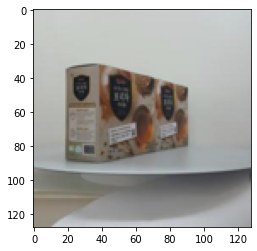

In [18]:
plt.imshow(data1[11])
plt.show()

## 5. data generator

In [19]:
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict()

# Train
train_datagen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range = 20,
        # brightness_range=[0.6,1.0],
    **datagen_kwargs
)

train_generator = train_datagen.flow(
    train_images, 
    y=train_labels,
    **dataflow_kwargs
)

# Validation
valid_datagen = ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow(
    valid_images,
    y=valid_labels,
    shuffle=False, 
    **dataflow_kwargs
)

# # Test
# test_datagen = ImageDataGenerator(**datagen_kwargs)
# test_generator = test_datagen.flow(
#     test_images, 
#     y=names_test, 
#     shuffle=False, 
#     **dataflow_kwargs
# )

## 6. MLP 모델

In [20]:
image_height = 64
image_width = 64
image_channel = 3

In [21]:
def MLP(img_size):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512,activation='relu'))
    model.add(tf.keras.layers.Dense(units=256,activation='relu'))
    model.add(tf.keras.layers.Dense(units=1000,activation='softmax'))
    
    return model

model = MLP(64)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               6291968   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              257000    
Total params: 6,680,296
Trainable params: 6,680,296
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
# 처음 만든 모델이라면 EPOCHS를 1~5개로 하여 잘 돌아가는지 
# 성능을 확인해보고 값을 증가 시켜 봅시다. 
EPOCHS = 100

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(
    train_images,
    train_labels, 
    validation_data = (valid_images, valid_labels),
    epochs=EPOCHS
)

Epoch 1/100
1200/1200 [==============================] - 5s 4ms/step - loss: 209.5110 - accuracy: 8.3335e-04 - val_loss: 6.9123 - val_accuracy: 2.0833e-04
Epoch 2/100
1200/1200 [==============================] - 4s 4ms/step - loss: 7.0002 - accuracy: 0.0011 - val_loss: 6.9158 - val_accuracy: 2.0833e-04
Epoch 3/100
1200/1200 [==============================] - 4s 4ms/step - loss: 6.9074 - accuracy: 0.0014 - val_loss: 6.9186 - val_accuracy: 2.0833e-04
Epoch 4/100
1200/1200 [==============================] - 4s 4ms/step - loss: 6.9072 - accuracy: 9.8554e-04 - val_loss: 6.9211 - val_accuracy: 2.0833e-04
Epoch 5/100
1200/1200 [==============================] - 4s 4ms/step - loss: 6.9069 - accuracy: 9.8731e-04 - val_loss: 6.9232 - val_accuracy: 2.0833e-04
Epoch 6/100
1200/1200 [==============================] - 4s 4ms/step - loss: 6.9069 - accuracy: 0.0013 - val_loss: 6.9249 - val_accuracy: 2.0833e-04
Epoch 7/100
1200/1200 [==============================] - 4s 4ms/step - loss: 6.9062 - accura